# 1. Embedding single image

In [ ]:
#!pip install git+https://github.com/openai/CLIP.git

In [12]:
import torch
import clip
from PIL import Image

# Load the model (once globally)
clip_model, preprocess_clip = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

def remove_alpha(image: Image.Image, background=(255, 255, 255)):
    """Convert RGBA to RGB with white background"""
    if image.mode in ('RGBA', 'LA'):
        bg = Image.new("RGB", image.size, background)
        bg.paste(image, mask=image.split()[-1])  # Use alpha channel as mask
        return bg
    else:
        return image.convert("RGB")

def get_image_embedding(image: Image.Image):
    """
    Returns a normalized CLIP embedding for a PIL image, with transparent background replaced.
    """
    # Ensure transparent background is handled
    image = remove_alpha(image)

    # Preprocess and encode
    image_input = preprocess_clip(image).unsqueeze(0).to(next(clip_model.parameters()).device)

    with torch.no_grad():
        embedding = clip_model.encode_image(image_input)
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)

    return embedding.cpu().squeeze(0)  # shape: (512,)


In [13]:
img = Image.open("data_set_collection\\data_set\\torso\\torso_trn063.png").convert("RGB")
embedding = get_image_embedding(img)

print(embedding.shape)  # torch.Size([512])
print(embedding[:5])

torch.Size([512])
tensor([-0.0179,  0.0147, -0.0339, -0.0059,  0.0443], dtype=torch.float16)


# 2. Embedding folder

In [14]:
import os
import torch
from PIL import Image
from tqdm import tqdm  # optional for progress bar

def embed_folder(folder_path, output_path):
    embeddings = []
    filenames = []

    # Walk through all .png files in the folder
    for filename in tqdm(sorted(os.listdir(folder_path))):
        if filename.lower().endswith(".png"):
            path = os.path.join(folder_path, filename)
            try:
                img = Image.open(path).convert("RGB")
                emb = get_image_embedding(img)
                embeddings.append(emb)
                filenames.append(filename)
            except Exception as e:
                print(f"⚠️ Failed to embed {filename}: {e}")

    # Stack all into a tensor
    embedding_tensor = torch.stack(embeddings)

    # Save both embeddings and filenames
    torch.save({
        "filenames": filenames,
        "embeddings": embedding_tensor
    }, output_path)

    print(f"✅ Saved {len(filenames)} embeddings to {output_path}")


In [15]:
embed_folder("data_set_collection\\data_set\\torso", "torso_embeddings.pt")

100%|██████████| 13300/13300 [00:58<00:00, 228.59it/s]


✅ Saved 13300 embeddings to torso_embeddings.pt


In [16]:
embed_folder("data_set_collection\\data_set\\legs", "legs_embeddings.pt")

100%|██████████| 13297/13297 [00:55<00:00, 237.73it/s]

✅ Saved 13297 embeddings to legs_embeddings.pt


In [17]:
embed_folder("data_set_collection\\data_set\\head", "head_embeddings.pt")

100%|██████████| 13300/13300 [00:55<00:00, 239.74it/s]

✅ Saved 13300 embeddings to head_embeddings.pt


# 3. Using embeddings to find similar parts

In [18]:
import torch
import torch.nn.functional as F
import os

def find_similar_head(query_img: Image.Image, top_k=10, head_folder="data_set/head"):
    try:
        query_img = remove_alpha(query_img).convert("RGB")
        query_emb = get_image_embedding(query_img).unsqueeze(0).cpu()

        data = torch.load("head_embeddings.pt", weights_only=True)
        embeddings = data["embeddings"].cpu()
        filenames = data["filenames"]

        sim = F.cosine_similarity(query_emb, embeddings)
        topk = torch.topk(sim, k=top_k)
        top_scores = topk.values.tolist()
        top_filenames = [filenames[i] for i in topk.indices.tolist()]

        print(f"\n🔍 Top {top_k} most similar heads:")
        for i, (fname, score) in enumerate(zip(top_filenames, top_scores), 1):
            print(f"{i:>2}. {fname:25}  score: {score:.4f}")

        return list(zip(top_filenames, top_scores))

    except Exception as e:
        print(f"🔥 Error during similarity search: {e}")
        return []

In [19]:
head_folder = "data_set_collection\\data_set\\head"
#img = Image.open("data_set_collection\\data_set\\head\\head_but021.png").convert("RGB")
img = Image.open("test_face2.png")
find_similar_head(img,head_folder=head_folder)


🔍 Top 10 most similar heads:
 1. head_idea109.png           score: 0.5991
 2. head_sim042.png            score: 0.5894
 3. head_dp075.png             score: 0.5850
 4. head_soc162.png            score: 0.5845
 5. head_cas209.png            score: 0.5796
 6. head_sw0858.png            score: 0.5776
 7. head_fort001.png           score: 0.5742
 8. head_sw0818.png            score: 0.5693
 9. head_sh0999.png            score: 0.5684
10. head_spp010.png            score: 0.5649


[('head_idea109.png', 0.59912109375),
 ('head_sim042.png', 0.58935546875),
 ('head_dp075.png', 0.5849609375),
 ('head_soc162.png', 0.58447265625),
 ('head_cas209.png', 0.57958984375),
 ('head_sw0858.png', 0.57763671875),
 ('head_fort001.png', 0.57421875),
 ('head_sw0818.png', 0.5693359375),
 ('head_sh0999.png', 0.568359375),
 ('head_spp010.png', 0.56494140625)]

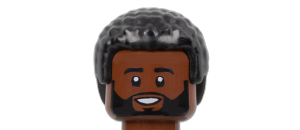

In [20]:
Image.open("data_set_collection\\data_set\\head\\head_idea109.png")

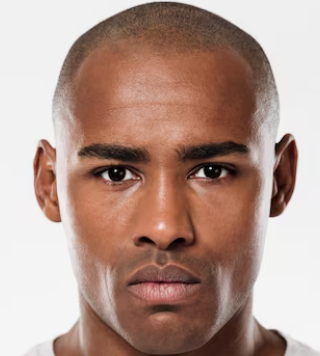

In [39]:
Image.open("test_face2.png")

# Model works. Now we can build stand alone solution